In [1]:
import os
import numpy as np
from landlab import RasterModelGrid
import landlab
from landlab.io import read_esri_ascii
from landlab.components import FlowAccumulator, FastscapeEroder, SedDepEroder,LinearDiffuser, ErosionDeposition, DepressionFinderAndRouter
from landlab.io.esri_ascii import write_esri_ascii
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def CountLinesAndColumns(fileName):        
    with open(fileName) as file:
        lines_after_6 = file.readlines()[5:]
   
    splitLine = lines_after_6[0].split()
    numberOfColumns = len(splitLine)        
    numberOfLines = lines_after_6.__len__()        
    grid = np.zeros((numberOfLines, numberOfColumns))    
    for i in range(numberOfLines):
        splitLine = lines_after_6[i].split()
        for j in range(numberOfColumns):
            grid[i][j] = splitLine[j]            
    file.close()                            
    return numberOfLines, numberOfColumns, grid

In [3]:
def plotdem(grid):
    plt.imshow(grid, interpolation = 'quadric', vmin = grid.min(), vmax = grid.max())
    plt.colorbar()
    plt.show()

In [4]:
def get_grid_folder(folder_name):
    loops = range(10000)
    grids = []
    
    for loop in loops:
        file_name = str(loop) + "_topographic__elevation.asc"
        (grid, _) = read_esri_ascii("./{folder_name}/{file_name}".format(folder_name=folder_name, file_name=file_name), name="topographic__elevation")
        grids.append(grid)
     
    return grids

In [5]:
def get_mean(grids):
    return list(map(lambda x: np.mean(x.at_node['topographic__elevation']), grids))

def load_grid(folder_name, init, end):
    print("Init: {}, End: {}".format(init, end))
    loops = range(init, end, 1)
    grids = []
    
    for loop in loops:
        file_name = str(loop) + "_topographic__elevation.asc"
        (grid, _) = read_esri_ascii("./{folder_name}/{file_name}".format(folder_name=folder_name, file_name=file_name), name="topographic__elevation")
        grids.append(grid)
     
    return grids

def get_means_long(folder_name, size, step=1000):
    
    if size < step:
        return get_mean(load_grid(folder_name, 0, step))
    
    arr = range(size)
    
    times = round(size / step)
    
    means = []
    for i in range(times):
        means.append(get_mean(load_grid(folder_name, step*i, step*(i+1))))
        
    means = np.array(means).flatten()
        
    resto = size % step
    np.append(means, get_mean(load_grid(folder_name, step*times, step*times + resto)))
    
    return means

In [6]:
m = get_means_long("testes_continentais", 10000)
m.shape

Init: 0, End: 1000


FileNotFoundError: [Errno 2] No such file or directory: './testes_continentais/0_topographic__elevation.asc'

In [ ]:
plt.plot(m)

## importar DEM

In [7]:
(mg_origin, z) = read_esri_ascii("./testes_continentais/random_matrix.asc", name="topographic__elevation")

(mg, z) = read_esri_ascii("./testes_continentais/random_matrix.asc", name="topographic__elevation")
mg.at_node.keys()

['topographic__elevation']

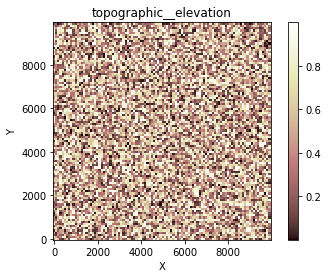

In [8]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation') 

## Definir condiçoes de borda

In [9]:
mg.BC_LINK_IS_FIXED
#mg.set_fixed_value_boundaries_at_grid_edges(right, top, left, bottom)
mg.set_fixed_value_boundaries_at_grid_edges(True, True, True, True)

## creating components

In [10]:

fr = FlowAccumulator(mg, flow_director='D8') 
df = DepressionFinderAndRouter(mg)
sp = FastscapeEroder(mg, K_sp=0.00002, m_sp=0.4, n_sp=1.0, threshold_sp= 0.0) #k eh erodibilidade, usar 0.0004
#FastscapeEroder(grid, K_sp=0.001, m_sp=0.5, n_sp=1.0, threshold_sp=0.0, discharge_field='drainage_area', erode_flooded_nodes=True)
lin_diffuse = LinearDiffuser (mg, linear_diffusivity = 0.01)


## run components

In [11]:
nl, nc, grid = CountLinesAndColumns("./testes_continentais/random_matrix.asc")
uplift_rate = 0.000
time_step = 1000 #time step linear diffuser component
fr.run_one_step()
df.map_depressions()

for i in range(1):
    print(i)
    #fr.run_one_step()
    sp.run_one_step(time_step) #dt eh multiplicador da formula e do threshold,
    #df.map_depressions()
    mg.at_node['topographic__elevation'] += time_step * uplift_rate 
    lin_diffuse.run_one_step(time_step) 
#     if i ==1000  or i == 2000 or i == 4000 or i == 6000 or i == 8000 or i == 10000:
    files = write_esri_ascii("./testes_continentais/psubstra_"+str(i)+".asc", mg)


0


In [12]:
grids = get_grid_folder("testes_continentais")

FileNotFoundError: [Errno 2] No such file or directory: './testes_continentais/0_topographic__elevation.asc'

In [ ]:
means = list(map(lambda x: np.mean(x.at_node['topographic__elevation']), grids))

In [ ]:
plt.plot(means)

In [ ]:
means